In [408]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import sklearn.datasets
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer

from sklearn.linear_model import LogisticRegression, Lars, LarsCV, LassoLars
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from credoai.lens import Lens
from credoai.artifacts import ClassificationModel, TabularData, RegressionModel
from credoai.evaluators import ModelFairness, Performance

import warnings
warnings.filterwarnings('ignore')

In [409]:
def set_seed(seed):
    'Sets the seed of the entire notebook so results are the same every time we run. This is for REPRODUCIBILITY.'
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
def summary(df):
    summ = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summ['null'] = df.isnull().sum()
    summ['unique'] = df.nunique()
    summ['min'] = df.min()
    summ['median'] = df.median()
    summ['max'] = df.max()
    summ['mean'] = df.mean()
    summ['std'] = df.std()
    return summ
    
set_seed(400)

In [410]:
ds = sklearn.datasets.load_diabetes(as_frame=True, scaled=False)

In [441]:
scale_xf = ColumnTransformer(
    [
        (
            'std_scaler',
            StandardScaler(),
            ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
        )
    ],
    verbose_feature_names_out=False,
    remainder='passthrough'
).set_output(transform='pandas')

def normalize_to_bool(row):
    if row.target > 150:
        row.target = True
    else:
        row.target = False

    return row

def normalize_to_bool_biased(row):
    if row.sex == 1.0:
        if row.target > 100:
            row.target = True
        else:
            row.target = False
    else:
        if row.target > 150:
            row.target = True
        else:
            row.target = False
    return row
        

orig_data = ds.frame.copy().apply(normalize_to_bool, axis=1)
# bias_data = ds.frame.copy().apply(normalize_to_bool_biased, axis=1)

train_orig_data = orig_data.drop(columns=["target"])
# train_bias_data = bias_data.drop(columns=["target"])
target_orig_data = orig_data.target
# target_bias_data = bias_data.target

train_orig_data



,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,59.0,2.0,32.1,101.00,157.0,93.2,38.0,4.00,4.8598,87.0
1,48.0,1.0,21.6,87.00,183.0,103.2,70.0,3.00,3.8918,69.0
2,72.0,2.0,30.5,93.00,156.0,93.6,41.0,4.00,4.6728,85.0
3,24.0,1.0,25.3,84.00,198.0,131.4,40.0,5.00,4.8903,89.0
4,50.0,1.0,23.0,101.00,192.0,125.4,52.0,4.00,4.2905,80.0
...,...,...,...,...,...,...,...,...,...,...
437,60.0,2.0,28.2,112.00,185.0,113.8,42.0,4.00,4.9836,93.0
438,47.0,2.0,24.9,75.00,225.0,166.0,42.0,5.00,4.4427,102.0
439,60.0,2.0,24.9,99.67,162.0,106.6,43.0,3.77,4.1271,95.0
440,36.0,1.0,30.0,95.00,201.0,125.2,42.0,4.79,5.1299,85.0


In [466]:
set_seed(400)
train_xf = Pipeline(
    [
        ('scale_xf', scale_xf),
        ('cla', KNeighborsClassifier())
    ]
).set_output(transform='pandas')

params = [
    {
        'cla': (KNeighborsClassifier(),),
        'cla__n_neighbors': [3, 5, 7],
        'cla__weights': ['uniform', 'distance']
    },
    {
        'cla': (MLPClassifier(),),
        'cla__hidden_layer_sizes': [(80,), (90,), (100,), (120,)],
        'cla__activation': ['logistic', 'relu', 'tanh'],
        'cla__solver': ['sgd'],
        'cla__learning_rate': ['adaptive', 'constant'],
        'cla__max_iter': [3500],
        'cla__random_state': [1]
    },
    # {
    #     'cla': (DecisionTreeClassifier(),),
    #     'cla__criterion': ['gini', 'entropy'],
    #     'cla__max_depth': [5, 8, 10]
    # },
    # {
    #     'cla': (RandomForestClassifier(),),
    #     'cla__n_estimators': [50, 100, 150],
    #     'cla__max_depth': [5, 8, 10]
    # }
]   

gs = GridSearchCV(
    estimator=train_xf,
    param_grid=params,
    scoring='roc_auc',
    error_score='raise',
    cv=5,
    verbose=1,  # Set to 10 to print traces and know the % progress (very verbose)
    n_jobs=-2   # -1 uses all CPU cores; you can give a number > 0 to use that number of cores
)

In [467]:
gs.fit(train_orig_data, target_orig_data)
best_train_xf = gs.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [468]:
display(pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score').reset_index(drop=True).head(5))
best_train_xf.predict(train_bias_data)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cla,param_cla__n_neighbors,param_cla__weights,param_cla__activation,param_cla__hidden_layer_sizes,param_cla__learning_rate,...,param_cla__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.612849,0.292474,0.039977,0.016240,"MLPClassifier(max_iter=3500, random_state=1, s...",NaN,NaN,relu,"(100,)",constant,...,sgd,"{'cla': MLPClassifier(max_iter=3500, random_st...",0.80000,0.911735,0.807812,0.846875,0.854688,0.844222,0.039889,1
1,2.898135,0.408366,0.028717,0.003026,"MLPClassifier(max_iter=3500, random_state=1, s...",NaN,NaN,relu,"(100,)",adaptive,...,sgd,"{'cla': MLPClassifier(max_iter=3500, random_st...",0.80000,0.911735,0.807812,0.846354,0.854688,0.844118,0.039883,2
2,1.182012,0.020762,0.042995,0.014868,"MLPClassifier(max_iter=3500, random_state=1, s...",NaN,NaN,tanh,"(80,)",constant,...,sgd,"{'cla': MLPClassifier(max_iter=3500, random_st...",0.79898,0.903571,0.805729,0.844792,0.860417,0.842698,0.038215,3
3,1.771418,0.298018,0.033203,0.003006,"MLPClassifier(max_iter=3500, random_state=1, s...",NaN,NaN,tanh,"(80,)",adaptive,...,sgd,"{'cla': MLPClassifier(max_iter=3500, random_st...",0.79949,0.903571,0.805729,0.843229,0.859896,0.842383,0.038039,4
4,1.210321,0.105831,0.027712,0.010391,"MLPClassifier(max_iter=3500, random_state=1, s...",NaN,NaN,tanh,"(120,)",constant,...,sgd,"{'cla': MLPClassifier(max_iter=3500, random_st...",0.80102,0.892857,0.798437,0.853646,0.861458,0.841484,0.036541,5


array([ True, False,  True,  True, False, False, False, False, False,
        True, False, False, False,  True, False,  True,  True,  True,
       False, False, False, False, False,  True, False, False, False,
        True, False,  True, False, False,  True, False, False, False,
        True, False,  True, False, False, False, False, False,  True,
       False, False, False, False,  True,  True,  True, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False,  True,
        True, False, False, False,  True, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True, False, False, False,  True,  True, False,
       False,  True, False, False, False, False, False, False, False,
        True, False, False, False, False,  True,  True,  True,  True,
        True,  True, False, False,  True,  True, False, False,  True,
       False, False,

In [469]:
credo_model = ClassificationModel(name="diabetes-classifier",
                                  model_like=best_train_xf)
credo_data = TabularData(
    name="diabetes-test1",
    X=train_orig_data,
    y=target_orig_data,
    sensitive_features=train_orig_data.sex
)

lens = Lens(model=credo_model, assessment_data=credo_data)

metrics = ['precision_score', 'recall_score', 'equal_opportunity']
lens.add(ModelFairness(metrics=metrics))
lens.add(Performance(metrics=metrics))
lens.run()

fairness_results = lens.get_results(evaluator_name='ModelFairness')[0]
results = lens.get_results()

aggr = fairness_results['results'][0]
disaggr = fairness_results['results'][1]

display(disaggr)
display(aggr)

results


2023-04-21 11:01:27,523 - lens - INFO - Evaluator ModelFairness added to pipeline. Sensitive feature: sex
2023-04-21 11:01:27,609 - lens - INFO - Evaluator Performance added to pipeline. 
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


,sex,type,value
0,1.0,precision_score,0.761364
1,2.0,precision_score,0.787879
2,1.0,recall_score,0.644231
3,2.0,recall_score,0.8125


,type,value
0,equal_opportunity,0.168269
0,precision_score_parity,0.026515
1,recall_score_parity,0.168269


[{'metadata': {'evaluator': 'ModelFairness',
   'sensitive_feature': 'sex',
   'dataset_type': 'assessment_data'},
  'results': [                     type     value
   0       equal_opportunity  0.168269
   0  precision_score_parity  0.026515
   1     recall_score_parity  0.168269,
      sex             type     value
   0  1.0  precision_score  0.761364
   1  2.0  precision_score  0.787879
   2  1.0     recall_score  0.644231
   3  2.0     recall_score    0.8125,
      true_label predicted_label     value  sens_feat_group
   0       False           False  0.839695              1.0
   1        True           False  0.355769              1.0
   2       False            True  0.160305              1.0
   3        True            True  0.644231              1.0
   4       False           False  0.810811              2.0
   5        True           False  0.187500              2.0
   6       False            True  0.189189              2.0
   7        True            True  0.812500         

[Text(0, 0, 'Male'), Text(1, 0, 'Female')]

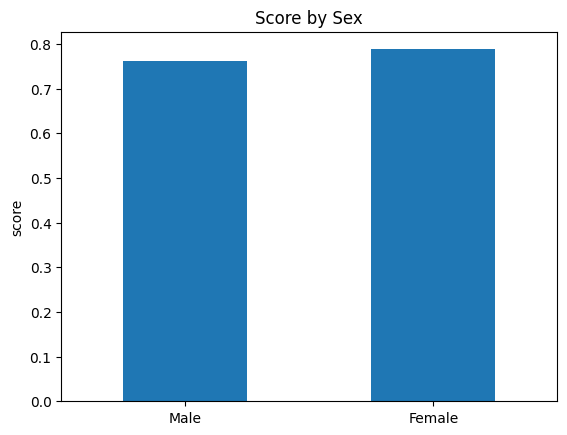

In [470]:
graph = disaggr[['sex', 'value']] \
             .head(2) \
             .rename(columns={'value': 'Score'}) \
             .replace({2: 'Female', 1: 'Male'})

plot = graph.plot.bar(ylabel='score', legend=False, title='Score by Sex')
plot.set_xticklabels(graph.sex,
                     rotation=0)